In [34]:
#Importem tot el necessari:
from pylab import *
from scipy.optimize import curve_fit
%matplotlib inline

## Input parameters:

In [61]:
#BACTERIA:
N = 10000
v0 = 2 #um/s
lam = 1 #s^-1

#BOX (Square simulation box)
L = 400 #um 
#Discretisation for density computation
n=100
dx = L/n #um 

# Time step in seconds
dt = 0.1 #s

## Classes and methods

In [62]:
class Bacteria:

    def __init__(self, N, v0, lam):
        self.N = N
        self.v0 = v0
        self.lam = lam
        self.pos = zeros((2,N))
        self.vel = ones(N)*v0
        self.theta = random(N)*2*pi
        self.dir = array([cos(self.theta), sin(self.theta)])

    def distribute(self, L):
        self.pos = random((2,N))*L
        
    def evolve(self, dt):
        self.v=vprofile(self.pos)
        self.pos += dt*self.v*self.dir
        self.tumble(dt)
        self.boundary(L)
        
    def tumble(self, dt):
        r = random(self.N)
        cond = r<self.lam*dt
        ntumbles = count_nonzero(cond)
        theta = random(ntumbles)*2*pi
        self.theta[cond] = theta
        self.dir[:,cond] = array([cos(theta), sin(theta)])
        
    # PBC    
    def boundary(self, L):
        self.pos[self.pos>L]-=L
        self.pos[self.pos<0]+=L

        
def vprofile(pos):
    v=v0+pos[0]*0.05
    return(v)          


class density:
    def __init__(self, cells, n, dx):
        self.n = n
        self.dx=dx
        self.counts=zeros((self.n,self.n))    

    def snapshot(self,pos):      
        self.counts,bin_edges,bars=histogram2d(cells.pos[0], cells.pos[1], bins=(n,n))




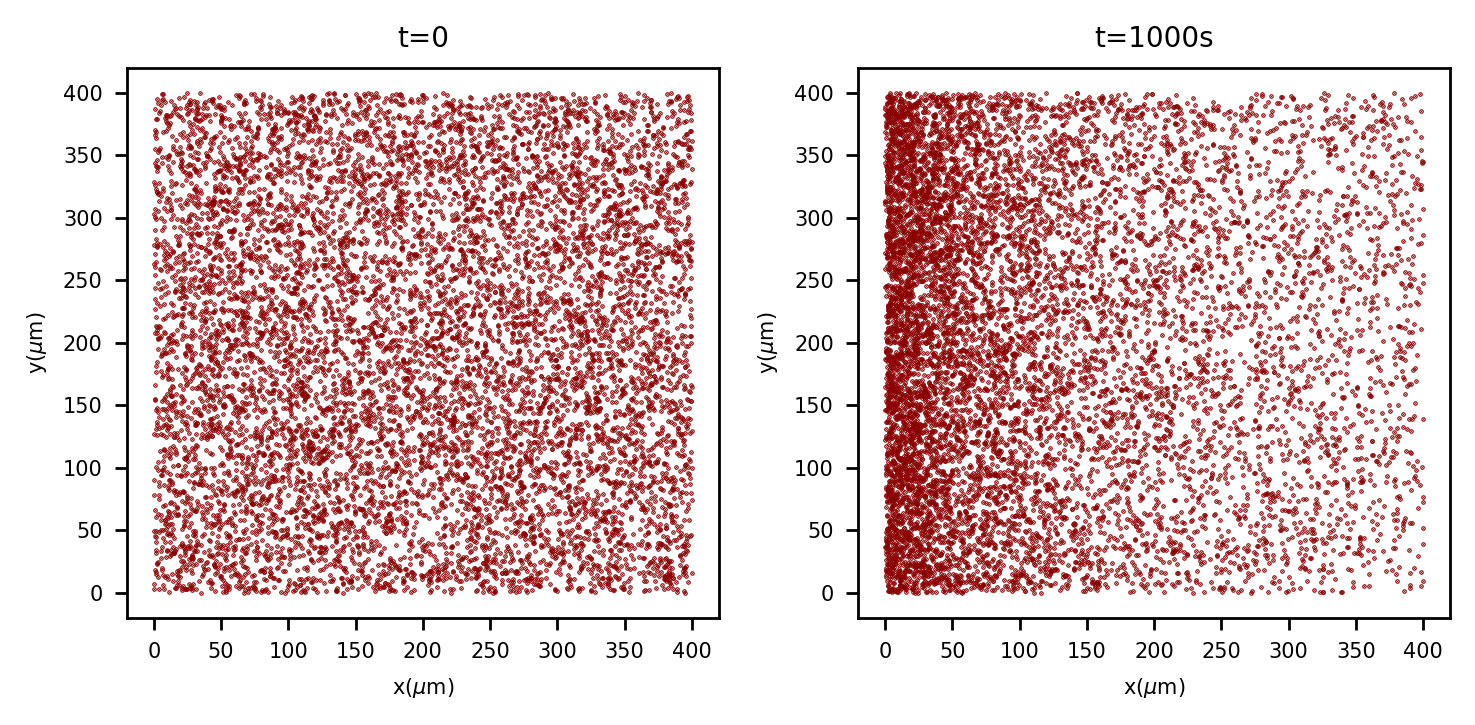

In [63]:
cells = Bacteria(N, v0, lam)
cells.distribute(L)

steps = 10000

#-------------------------------------------------------------------------------
# plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,3),dpi=250)
mysize=6
axes[0].set_title('t=0',fontsize=mysize+2)
axes[0].set_xlabel('x($\mu$m)',fontsize=mysize)
axes[0].set_ylabel('y($\mu$m)',fontsize=mysize)
axes[0].tick_params(labelsize=mysize)
#axes[0].set_xlim(right=L,left=0)
#axes[0].set_ylim(top=L,bottom=0)
axes[1].set_title('t=' + str(round(steps*dt)) + 's',fontsize=mysize+2)
axes[1].set_xlabel('x($\mu$m)',fontsize=mysize)
axes[1].set_ylabel('y($\mu$m)',fontsize=mysize)
axes[1].tick_params(labelsize=mysize)
#axes[1].set_xlim(right=L,left=0)
#axes[1].set_ylim(top=L,bottom=0)
#-------------------------------------------------------------------------------
axes[0].scatter(cells.pos[0],cells.pos[1],s=0.1,color='darkred',alpha=1)


for i in range(steps):
    cells.evolve(dt)    

axes[1].scatter(cells.pos[0],cells.pos[1],s=0.1,color='darkred',alpha=1)
fig.tight_layout()

## Checking $\rho$ $\propto 1/v$

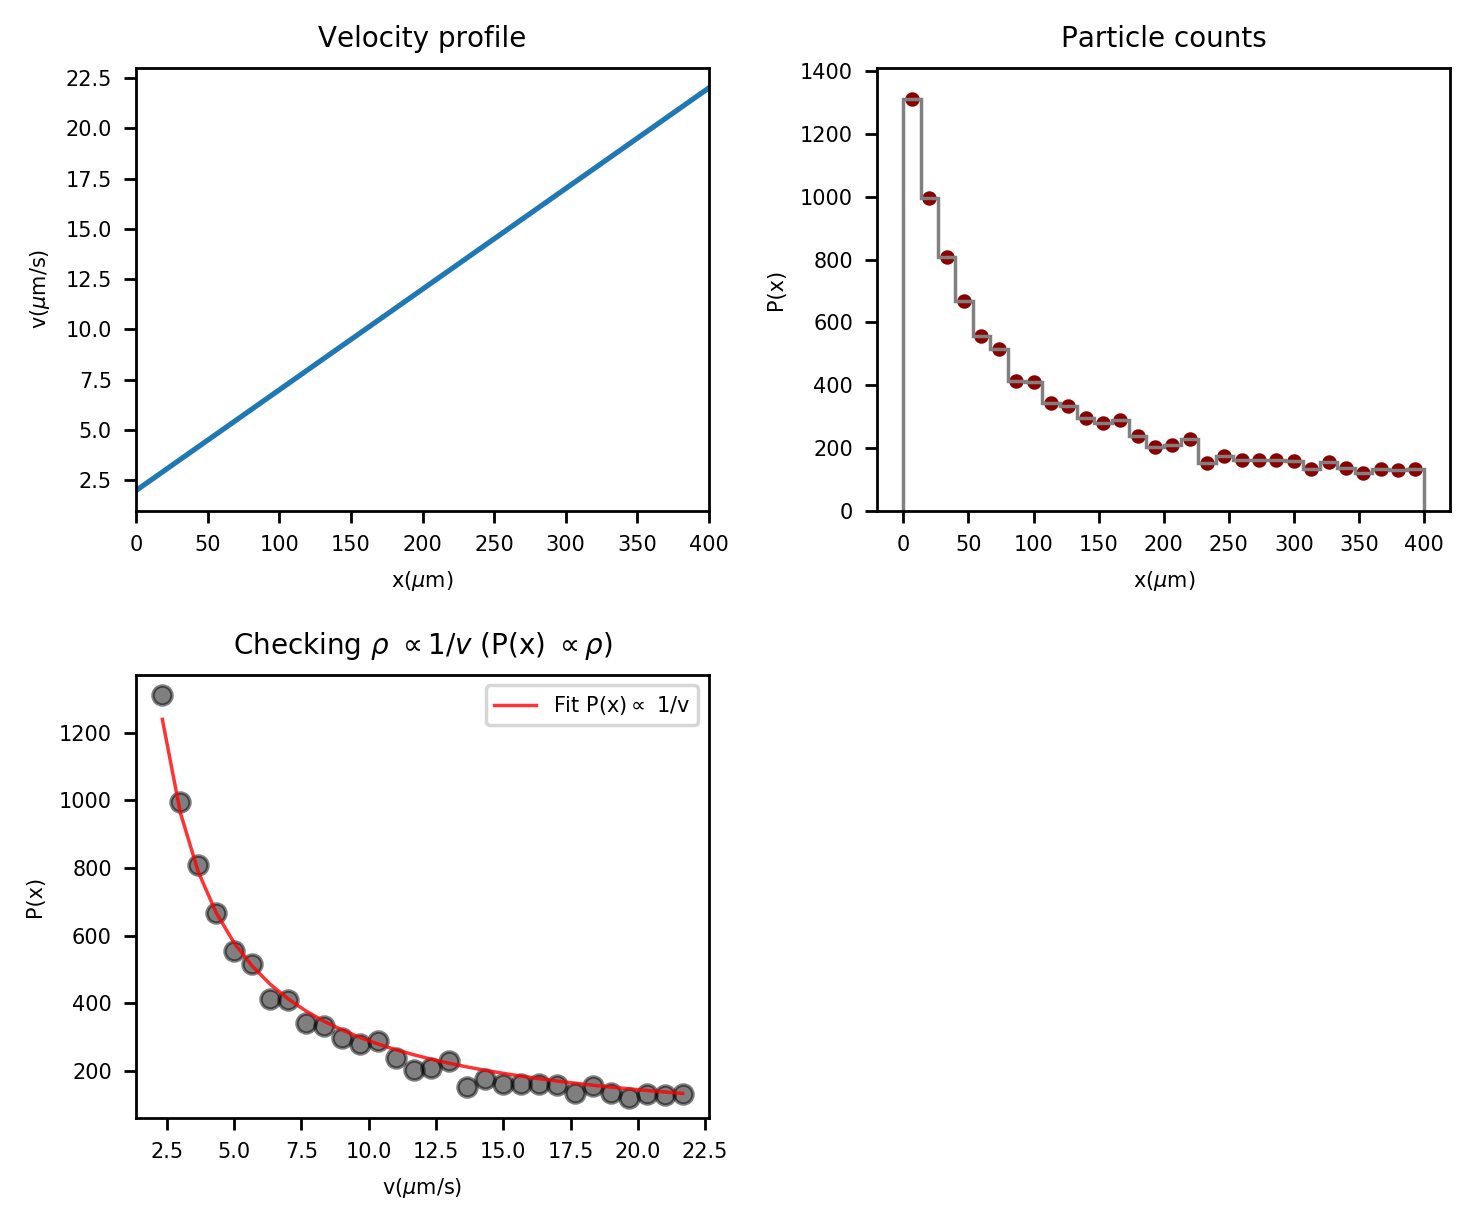

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6,5),dpi=250)


#-------------------------------------------------------------------------------
# velocity profile
posp=zeros((2,N))
posp[0] = linspace(0,L,N)
posp[1] = L/2

mysize=6
axes[0,0].set_title('Velocity profile',fontsize=mysize+2)
axes[0,0].set_xlabel('x($\mu$m)',fontsize=mysize)
axes[0,0].set_ylabel('v($\mu$m/s)',fontsize=mysize)
axes[0,0].tick_params(labelsize=mysize)
axes[0,0].set_xlim(right=L,left=0)

vi=vprofile(posp)
axes[0,0].plot(posp[0],vi)

#-------------------------------------------------------------------------------
#plot histogram of counts of particles


nbins=30

counts, bin_edges,bars=axes[0,1].hist(cells.pos[0], bins=nbins, histtype='step',color='grey')

wid=bin_edges[1]-bin_edges[0]
xx=bin_edges[1:nbins+1]-wid/2
rhom=counts[0:nbins]

axes[0,1].set_title('Particle counts',fontsize=mysize+2)
axes[0,1].scatter(xx,rhom,s=10,color='darkred')

axes[0,1].set_ylim(top=max(counts)+100,bottom=0)
axes[0,1].set_xlabel('x($\mu$m)',fontsize=mysize)
axes[0,1].set_ylabel('P(x)',fontsize=mysize)
axes[0,1].tick_params(labelsize=mysize)

#-------------------------------------------------------------------------------
#fit P(x) to 1/v

#velocity each bar of thr histogram:
posis=zeros((2,size(xx)))
posis[0]=xx
posis[1]=L/2
vbin=vprofile(posis)

axes[1,0].tick_params(labelsize=mysize)
axes[1,0].set_title('Checking $\\rho$ $\propto 1/v$ (P(x) $\propto \\rho$)',fontsize=mysize+2)
axes[1,0].scatter(vbin,rhom,s=30,color='black',alpha=0.5)
axes[1,0].set_xlabel('v($\mu$m/s)',fontsize=mysize)
axes[1,0].set_ylabel('P(x)',fontsize=mysize)

#Fit
def func(x, a):
    return a / x

popt, pcov = curve_fit(func, vbin, rhom)

axes[1,0].plot(vbin, func(vbin, popt[0]),color='red',alpha=0.8,linewidth=1,label='Fit P(x)$\propto$ 1/v')
axes[1,0].legend(fontsize=mysize)

axes[-1, -1].axis('off')

fig.tight_layout()


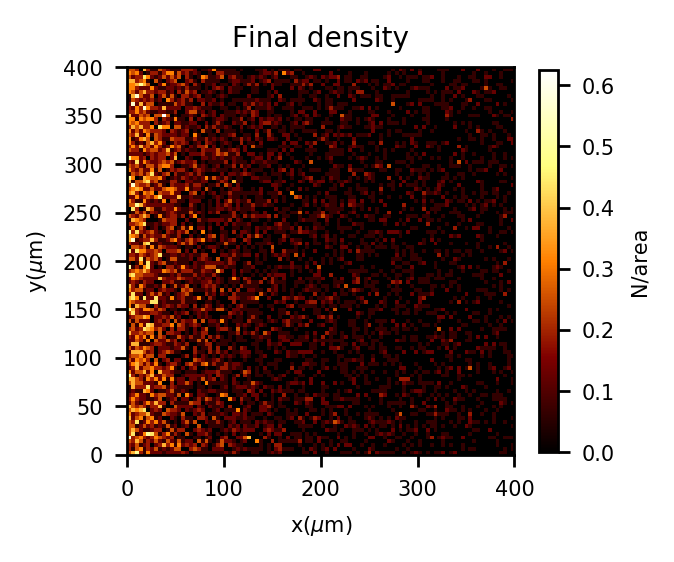

In [67]:
dens=density(cells, n, dx)
dens.snapshot(cells.pos)
rho=dens.counts/(dx*dx)

#et retorna counts que ve a ser el numero de particules a cada capsa

# Plot of the snapshot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(2.5,2.5),dpi=250)
mysize=6
axes.set_title('Final density',fontsize=mysize+2)
axes.set_xlabel('x($\mu$m)',fontsize=mysize)
axes.set_ylabel('y($\mu$m)',fontsize=mysize)
axes.tick_params(labelsize=mysize)

imshow(transpose(rho), origin='lower',extent=[0,L,0,L],cmap='afmhot')

cbar=colorbar(shrink=0.81)
cbar.set_label(label='N/area', size=mysize)
cbar.ax.tick_params(labelsize=mysize)
